In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from gmr import MVN
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from numpy import percentile
from scipy.stats import binned_statistic
import time
from joblib import Parallel, delayed
import cpuinfo

In [3]:
data = pd.read_csv('../data/healthcare_small.csv')
data = data.drop(columns=['Unnamed: 0'])
columns = data.columns.tolist()
#columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data

,A,C,D,H,I,O,T
0,young,none,0.000000,none,161.144909,79.584221,360.061297
1,old,mild,7.279929,any,4036.335955,294.419453,4541.096045
2,young,none,0.000000,none,96.168764,72.679291,302.139694
3,adult,mild,3.226699,any,1877.604065,194.558978,2234.841250
4,young,none,0.000000,none,92.837133,55.540747,272.980097
...,...,...,...,...,...,...,...
295,young,none,0.000000,none,44.151079,70.962600,242.453034
296,young,mild,0.000000,none,-19.724557,67.242511,192.573104
297,young,severe,0.000000,none,-12.693842,62.776971,174.033076
298,adult,none,0.000000,none,56.451896,184.445956,347.989476


In [19]:
data = data.sample(500)
data.reset_index(inplace=True, drop=True)

In [20]:
data.to_csv('socio_sample.csv', index=False)

In [21]:
data['sex'] = data['sex'].apply(lambda x: str(x))
data['relation'] = data['relation'].apply(lambda x: str(x))
data['is_parent'] = data['is_parent'].apply(lambda x: str(x))
data['has_pets'] = data['has_pets'].apply(lambda x: str(x))
data['age'] = data['age'].apply(lambda x: str(x))

In [4]:
node_types = get_nodes_type(data)
node_types

{'A': 'disc',
 'C': 'disc',
 'D': 'cont',
 'H': 'disc',
 'I': 'cont',
 'O': 'cont',
 'T': 'cont'}

In [5]:
node_signs = get_nodes_sign(data)
node_signs

{'D': 'neg', 'I': 'neg', 'O': 'pos', 'T': 'pos'}

In [6]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if node_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [7]:
data_coded, label_coder = code_categories(data, 'label', colums_for_code)
data_discrete, coder = discretization(data_coded, 'equal_frequency', columns_for_disc)

In [20]:
bn_full = structure_learning(data_coded, 'HC', node_types, 'LL')
bn_full

c:\Users\anaxa\Documents\Projects\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\bayesian\redef_HC.py:156: RuntimeWarning: invalid value encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\bayesian\redef_HC.py:156: RuntimeWarning: invalid value encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\bayesian\redef_HC.py:156: RuntimeWarning: invalid value encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\bayesian\redef_HC.py:156: RuntimeWarning: invalid value encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\bayesian\redef_HC.py:156: R

{'V': ['Tectonic regime',
  'Period',
  'Lithology',
  'Structural setting',
  'Depositional environment',
  'Gross',
  'Netpay',
  'Porosity',
  'Permeability',
  'Depth'],
 'E': [['Tectonic regime', 'Period'],
  ['Depositional environment', 'Period'],
  ['Structural setting', 'Period'],
  ['Tectonic regime', 'Lithology'],
  ['Lithology', 'Structural setting'],
  ['Tectonic regime', 'Depositional environment'],
  ['Structural setting', 'Depositional environment'],
  ['Tectonic regime', 'Gross'],
  ['Tectonic regime', 'Netpay'],
  ['Tectonic regime', 'Porosity'],
  ['Tectonic regime', 'Permeability'],
  ['Tectonic regime', 'Depth']]}

In [7]:
bn_full = dict()
bn_full['E'] = [['A', 'C'], ['A', 'D'], ['A', 'H'], ['A', 'O'], ['C', 'I'], ['D', 'I'], ['H', 'D'], ['I', 'T'], ['O', 'T']]
bn_full['V'] = columns

In [21]:
draw_BN(bn_full, node_types, 'geo_mi')

In [11]:
start_learn = time.time()
params = parameter_learning(data, node_types, bn_full, 'mix')
save_structure(bn_full, 'all_net_sangiovese')
skel = read_structure('all_net_sangiovese')
save_params(params, 'all_net_param_sangiovese')
params = read_params('all_net_param_sangiovese')
all_bn = HyBayesianNetwork(skel, params)
end_learn = time.time()

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning:

In [12]:
start_pred = time.time()
acc, rmse_mehra, real, pred, indexes = calculate_acc(all_bn, data, columns_for_disc, 'mix')
end_pred = time.time()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
len(real[4])

IndexError: list index out of range

In [10]:
rmse_mehra

{'D': 0.285, 'I': 0.04, 'O': 0.223, 'T': 0.011}

In [24]:
acc

{'A': 0.43, 'C': 0.73, 'H': 0.81}

In [49]:
end_learn - start_learn

0.604996919631958

In [50]:
end_pred - start_pred

154.506281375885

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

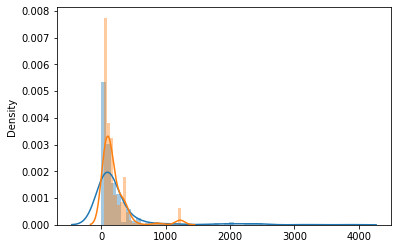

In [14]:
sns.distplot(real[0])
sns.distplot(pred[0])

In [18]:
mask = yhat != -1
geo[mask]

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Depositional environment,Gross,Netpay,Porosity,Permeability,Depth,Oil density,Oil recovery factor
0,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,OIL,SHELF-,76.2,30.5,21.0,60.0,1510.7,825.072886,0.26
1,GRAVITY,CRETACEOUS,LIMESTONE,PASSIVE MARGIN,OIL,SHELF-,29.0,4.6,12.0,20.0,2652.4,801.699717,0.34
2,EXTENSION,PALEOGENE,THINLY-BEDDED SANDSTONE,RIFT,OIL,SLOPE APRON,91.5,82.3,35.0,3500.0,1720.1,933.993399,0.36
3,STRIKE-SLIP,ORDOVICIAN,DOLOMITE,INTRACRATONIC,OIL,OPEN SHELF,182.9,122.0,4.0,10.0,1158.5,815.561960,0.48
4,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,OIL,SHELF-,91.5,32.0,10.0,20.0,1829.3,876.160991,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,LACUSTRINE FAN-DELTA,50.0,18.9,23.2,121.0,1439.3,946.488294,0.13
339,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,SUBLACUSTRINE FAN,89.9,24.1,21.0,60.0,2310.7,881.619938,0.19
340,EXTENSION,MESOZOIC,VOLCANICS,RIFT,OIL,NOT APPLICABLE,150.0,59.1,12.7,3.6,3000.9,870.769231,0.05
341,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,OIL,SHORELINE,79.9,10.1,24.0,30.0,570.1,887.147335,0.24


In [42]:
def n_comp_sample (size: int, d: int):
    d1_05 = [0.225, 0.417]
    d1_08 = [0.136, 0.79]
    d1_099 = [0.015, 1.391]
    d2_08 = [0.07, 0.703]
    d3_08 = [0.042, 0.547]
    n = 1
    if (size <= 50) & (d == 1):
        n = size*d1_05[0] + d1_05[1]
    if (size > 50) & (size <= 100) & (d == 1):
        n = size*d1_08[0] + d1_08[1]
    if (size > 100) & (d == 1):
        n = size*d1_099[0] + d1_099[1]
    if d == 2:
        n = size*d2_08[0] + d2_08[1]
    if d == 3:
        n = size*d3_08[0] + d3_08[1]
    return n


In [39]:
n = n_component(geo, ['Netpay'])
n

4

In [43]:
n_comp_sample(geo.shape[0], 1)

6.536

In [115]:
n=4

In [116]:
means = []
cov = []
w = [1/n for o in range(n)]
for i in range(n):
    means.append([random.randint(0, 1000)])
    cov.append([[random.randint(100, 300)]])

In [117]:
means

[[110], [847], [12], [686]]

In [118]:
cov

[[[111]], [[175]], [[257]], [[103]]]

In [119]:
m = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)

In [120]:
sample = m.sample(1000000)

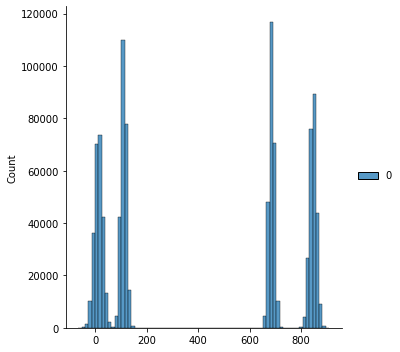

In [121]:
sns.displot(sample)

In [61]:
def LL_up (sample, n, means, cov, w):
    comp_dens = []
    for k in range (n):
        comp_dens.append(w[k]*MVN(mean=means[k], covariance=cov[k]).to_probability_density(sample))
    comp_dens = np.log(np.sum(comp_dens, axis=0))
    return np.mean(sample)*((np.sum(comp_dens)))

In [4]:
def LL_sample (sample, n, means, cov, w):
    comp_dens = []
    for k in range (n):
        comp_dens.append(w[k]*MVN(mean=means[k], covariance=cov[k]).to_probability_density(sample))
    comp_dens = np.log(np.sum(comp_dens, axis=0))
    return (np.sum(comp_dens))/len(sample)

In [76]:
LL_sample(sample, n, means, cov, w)

-4.6778808796811235

In [122]:
m1 = GaussianMixture(n_components=n).fit(sample)
round(m1.lower_bound_,3)

-5.312

In [57]:
def difference_ndarray(a, b):
    diff = []
    for element in a:
        if element not in b:
            diff.append(element)
    return(diff)

In [3]:
random_state = check_random_state(0)

In [127]:
n = 2
b = 0.99
mean_res = []
for k in range (10):
    print(k)
    means =[]
    cov = []
    w = [1/n for _ in range(n)]
    for i in range(n):
        means.append([random.randint(-1000, 1000)])
        cov.append([[random.randint(10, 500)]])
    generator = GMM(n_components=n, means=means, covariances=cov, priors=w)
    sample = generator.sample(10000000)
    m = GaussianMixture(n_components=n).fit(sample)
    test = generator.sample(10000000)
    LL = round(m.lower_bound_,3)
    dif = []
    step = 1
    for size in range (n+1,10000000,1):
        train = generator.sample(size)
        m1 = GaussianMixture(n_components=n).fit(train)
        ll_test = round(np.mean(m1.score_samples(test)),3)
        diff = LL - ll_test
        dif.append(diff)
        if diff <= -1*math.log(b):
            mean_res.append(size)
            break
        else:
            continue
    if size == 10000000-1:
        mean_res.append(size)

0
1
2
3
4
5
6
7
8
9


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

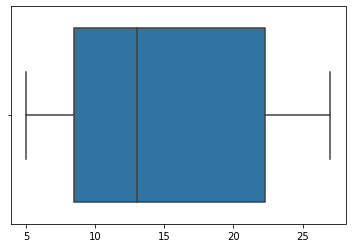

In [126]:
sns.boxplot(mean_res)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

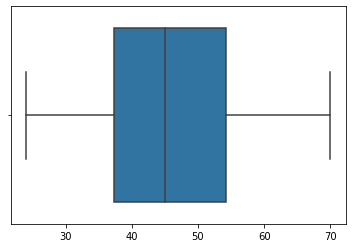

In [128]:
sns.boxplot(mean_res)

In [7]:
mean_param = []
cov_param = []
w_param = []
LL_theoretical = []
samples = []

In [8]:
beta = [0.8]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res = [[] for j in range(10)]
    for n in range(1, 11, 1):
        print(n)
        means = []
        cov = []
        w = [1/n for _ in range(n)]
        for _ in range(n):
            means.append([random.randint(-1000, 1000)])
            cov.append([[random.randint(100, 500)]])
        mean_param.append(means)
        cov_param.append(cov)
        w_param.append(w)
        generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
        sample = generator.sample(10000000)
        samples.append(sample)
        m = GaussianMixture(n_components=n).fit(sample)
        LL = round(m.lower_bound_,3)
        LL_theoretical.append(LL)
        for k in range(10):
            print(k)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                #train = sample[0:size+1]
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(sample)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res[n-1].append(size)
                        break
                    else:
                        continue

1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
3
0
1
2
3
4
5
6
7
8
9
4
0
1
2
3
4
5
6
7
8
9
5
0
1
2
3
4
5
6
7
8
9
6
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
8
0
1
2
3
4
5
6
7
8
9
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9


In [12]:
beta = [0.9]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res2 = [[] for j in range(10)]
    for n in range(1, 11, 1):
        print(n)
        means = mean_param[n-1]
        cov = cov_param[n-1]
        w = w_param[n-1]
        generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
        test = samples[n-1]
        LL = LL_theoretical[n-1]
        for k in range(10):
            print(k)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                # train = sample[0:size+1]
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res2[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res2[n-1].append(size)
                        break
                    else:
                        continue

1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
3
0
1
2
3
4
5
6
7
8
9
4
0
1
2
3
4
5
6
7
8
9
5
0
1
2
3
4
5
6
7
8
9
6
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
8
0
1
2
3
4
5
6
7
8
9
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9


In [103]:
mean_param

[[[776]],
 [[493], [-956]],
 [[-980], [537], [10]],
 [[766], [-794], [592], [-843]],
 [[944], [-646], [589], [-711], [-375]],
 [[452], [709], [-399], [830], [-710], [864]],
 [[-935], [-353], [646], [857], [721], [412], [-636]],
 [[-114], [-677], [463], [-494], [592], [396], [655], [124]],
 [[108], [743], [-72], [-190], [-649], [-6], [624], [910], [999]],
 [[-962], [416], [187], [215], [-717], [697], [-186], [-179], [254], [-522]]]

In [104]:
cov_param

[[[[136]]],
 [[[138]], [[425]]],
 [[[248]], [[283]], [[340]]],
 [[[178]], [[356]], [[267]], [[360]]],
 [[[440]], [[191]], [[176]], [[263]], [[154]]],
 [[[363]], [[408]], [[164]], [[205]], [[379]], [[469]]],
 [[[499]], [[419]], [[444]], [[383]], [[482]], [[205]], [[253]]],
 [[[375]], [[124]], [[441]], [[229]], [[132]], [[328]], [[320]], [[228]]],
 [[[324]],
  [[375]],
  [[105]],
  [[273]],
  [[232]],
  [[112]],
  [[430]],
  [[313]],
  [[392]]],
 [[[131]],
  [[281]],
  [[170]],
  [[164]],
  [[232]],
  [[241]],
  [[388]],
  [[188]],
  [[145]],
  [[348]]]]

In [105]:
w_param

[[1.0],
 [0.5, 0.5],
 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 [0.25, 0.25, 0.25, 0.25],
 [0.2, 0.2, 0.2, 0.2, 0.2],
 [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]

In [106]:
LL_theoretical

[-3.875, -4.857, -5.349, -5.505, -5.724, -5.954, -6.287, -6.219, -6.382, -6.19]

In [109]:
f=open('samples.txt','w')
for ele in samples:
    f.write(str(ele)+'\n')

In [33]:
mean_res

[[5, 6, 4, 6, 6, 4, 5, 3, 4, 2],
 [9, 7, 9, 11, 12, 9, 12, 10, 10, 11],
 [10, 20, 17, 16, 13, 15, 18, 10, 10, 11],
 [27, 14, 31, 21, 18, 21, 26, 25, 25, 26],
 [30, 28, 21, 33, 25, 35, 26, 37, 22, 30],
 [41, 36, 53, 44, 37, 40, 38, 39, 29, 39],
 [30, 47, 47, 52, 47, 54, 51, 37, 44, 44],
 [40, 59, 50, 58, 58, 59, 48, 50, 58, 47],
 [62, 67, 70, 54, 53, 67, 72, 66, 51, 56],
 [71, 72, 62, 85, 84, 65, 46, 66, 60, 77]]

In [34]:
beta = [0.8]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res1 = [[] for j in range(10)]
    for k in range(10):
        print(k)
        for n in range(1, 11, 1):
            print(n)
            means = mean_param[n-1]
            cov = cov_param[n-1]
            w = w_param[n-1]
            generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
            # sample = generator.sample(10000000)
            # m = GaussianMixture(n_components=n).fit(sample)
            LL = LL_theoretical[n-1]#round(m.lower_bound_,3)
            test = generator.sample(10000000)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res1[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res1[n-1].append(size)
                        break
                    else:
                        continue

0
1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
2
1
2
3
4
5
6
7
8
9
10
3
1
2
3
4
5
6
7
8
9
10
4
1
2
3
4
5
6
7
8
9
10
5
1
2
3
4
5
6
7
8
9
10
6
1
2
3
4
5
6
7
8
9
10
7
1
2
3
4
5
6
7
8
9
10
8
1
2
3
4
5
6
7
8
9
10
9
1
2
3
4
5
6
7
8
9
10


In [35]:
mean_res1

[[3, 4, 3, 2, 2, 2, 7, 4, 3, 3],
 [11, 10, 11, 8, 10, 13, 4, 8, 10, 5],
 [17, 16, 27, 14, 10, 17, 14, 17, 21, 17],
 [20, 14, 25, 27, 27, 24, 19, 24, 23, 26],
 [29, 35, 30, 30, 27, 36, 23, 38, 30, 35],
 [26, 39, 33, 44, 26, 26, 43, 44, 28, 46],
 [27, 43, 50, 38, 41, 45, 54, 42, 46, 37],
 [52, 60, 51, 67, 52, 60, 58, 55, 37, 54],
 [52, 59, 53, 65, 56, 66, 55, 53, 54, 46],
 [67, 62, 84, 67, 66, 53, 57, 58, 74, 53]]

In [73]:
mean_res = [[5, 6, 4, 6, 6, 4, 5, 3, 4, 2],
 [9, 7, 9, 11, 12, 9, 12, 10, 10, 11],
 [10, 20, 17, 16, 13, 15, 18, 10, 10, 11],
 [27, 14, 31, 21, 18, 21, 26, 25, 25, 26],
 [30, 28, 21, 33, 25, 35, 26, 37, 22, 30],
 [41, 36, 53, 44, 37, 40, 38, 39, 29, 39],
 [30, 47, 47, 52, 47, 54, 51, 37, 44, 44],
 [40, 59, 50, 58, 58, 59, 48, 50, 58, 47],
 [62, 67, 70, 54, 53, 67, 72, 66, 51, 56],
 [71, 72, 62, 85, 84, 65, 46, 66, 60, 77]]

In [75]:
mean_res1 = [[3, 4, 3, 2, 2, 2, 7, 4, 3, 3],
 [11, 10, 11, 8, 10, 13, 4, 8, 10, 5],
 [17, 16, 27, 14, 10, 17, 14, 17, 21, 17],
 [20, 14, 25, 27, 27, 24, 19, 24, 23, 26],
 [29, 35, 30, 30, 27, 36, 23, 38, 30, 35],
 [26, 39, 33, 44, 26, 26, 43, 44, 28, 46],
 [27, 43, 50, 38, 41, 45, 54, 42, 46, 37],
 [52, 60, 51, 67, 52, 60, 58, 55, 37, 54],
 [52, 59, 53, 65, 56, 66, 55, 53, 54, 46],
 [67, 62, 84, 67, 66, 53, 57, 58, 74, 53]]

In [89]:
df_men_res = pd.DataFrame(columns=['Only train random', 'Train&Test random', 'Train&Test random on each iter', 'Number of components'])

In [90]:
n = 1
m1 = []
m2 = []
m3 = []
components = []
for k1, k2, k3 in zip(mean_res, mean_res1, mean_res2):
    m1 += k1
    m2 += k2
    m3 += k3
    components += [n for _ in range(10)]
    n += 1

In [91]:
df_men_res['Only train random'] = m1
df_men_res['Train&Test random'] = m2
df_men_res['Train&Test random on each iter'] = m3
df_men_res['Number of components'] = components

In [92]:
dd=pd.melt(df_men_res,id_vars=['Number of components'],value_vars=['Only train random', 'Train&Test random', 'Train&Test random on each iter'],var_name='Experiments')

<AxesSubplot:xlabel='Number of components', ylabel='value'>

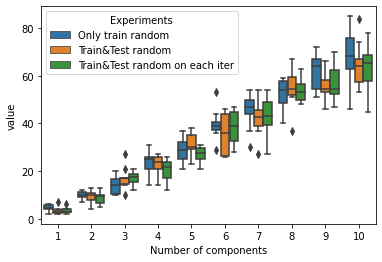

In [93]:
sns.boxplot(x='Number of components',y='value',data=dd,hue='Experiments')

In [25]:
beta = [0.85]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res = [[] for j in range(10)]
    mean_param = []
    cov_param = []
    w_param = []
    for k in range(10):
        print(k)
        for n in range(1, 11, 1):
            print(n)
            means = []
            cov = []
            w = [1/n for _ in range(n)]
            for i in range(n):
                means.append([random.randint(-1000, 1000)])
                cov.append([[random.randint(100, 500)]])
            mean_param.append(means)
            cov_param.append(cov)
            w_param.append(w)
            generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
            sample = generator.sample(10000000)
            m = GaussianMixture(n_components=n).fit(sample)
            LL = round(m.lower_bound_,3)
            test = generator.sample(10000000)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res[n-1].append(size)
                        break
                    else:
                        continue
            if size == 10000000-1:
                mean_res[n-1].append(size)
    # mean_vector = np.sum(mean_res, axis=0)
    # mean_vector = [u/1 for u in mean_vector]
    # results[number] = mean_vector

0
1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
2
1
2
3
4
5
6
7
8
9
10
3
1
2
3
4
5
6
7
8
9
10
4
1
2
3
4
5
6
7
8
9
10
5
1
2
3
4
5
6
7
8
9
10
6
1
2
3
4
5
6
7
8
9
10
7
1
2
3
4
5
6
7
8
9
10
8
1
2
3
4
5
6
7
8
9
10
9
1
2
3
4
5
6
7
8
9
10


In [5]:
beta = [0.99]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res = [[] for j in range(10)]
    mean_param = []
    cov_param = []
    w_param = []
    for k in range(10):
        print(k)
        for n in range(1, 11, 1):
            print(n)
            means = []
            cov = []
            w = [1/n for _ in range(n)]
            for i in range(n):
                means.append([random.randint(-1000, 1000), random.randint(-1000, 1000), random.randint(-1000, 1000)])
                cov.append(make_spd_matrix(3))
            mean_param.append(means)
            cov_param.append(cov)
            w_param.append(w)
            generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
            sample = generator.sample(10000000)
            m = GaussianMixture(n_components=n).fit(sample)
            LL = round(m.lower_bound_,3)
            test = generator.sample(10000000)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res[n-1].append(size)
                    break
                else:
                    if size > 5000:
                        mean_res[n-1].append(size)
                        break
                    else:
                        continue
            if size == 10000000-1:
                mean_res[n-1].append(size)

0
1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
2
1
2
3
4
5
6
7
8
9
10
3
1
2
3
4
5
6
7
8
9
10
4
1
2
3
4
5
6
7
8
9
10
5
1
2
3
4
5
6
7
8
9
10
6
1
2
3
4
5
6
7
8
9
10
7
1
2
3
4
5
6
7
8
9
10
8
1
2
3
4
5
6
7
8
9
10
9
1
2
3
4
5
6
7
8
9
10


In [6]:
mean_res

[[143, 72, 128, 141, 172, 85, 149, 182, 114, 138],
 [312, 465, 356, 436, 331, 343, 371, 398, 395, 392],
 [689, 709, 699, 766, 410, 744, 826, 613, 535, 768],
 [1149, 1007, 910, 1119, 1158, 883, 1069, 1057, 1038, 951],
 [1416, 1163, 1505, 1247, 1158, 1342, 936, 1437, 1447, 1419],
 [1623, 1724, 1649, 1753, 1596, 1783, 1642, 1902, 1622, 1908],
 [1723, 2097, 2115, 1915, 2153, 2267, 2382, 1954, 2253, 2230],
 [2399, 2413, 2324, 2156, 2476, 2098, 1895, 2437, 2427, 2524],
 [2686, 3433, 2704, 2864, 2801, 2594, 2516, 2482, 2773, 2940],
 [2495, 2981, 3423, 2923, 3297, 3511, 2833, 3152, 2704, 2767]]

In [9]:
mean_res = [[143, 72, 128, 141, 172, 85, 149, 182, 114, 138],
 [312, 465, 356, 436, 331, 343, 371, 398, 395, 392],
 [689, 709, 699, 766, 410, 744, 826, 613, 535, 768],
 [1149, 1007, 910, 1119, 1158, 883, 1069, 1057, 1038, 951],
 [1416, 1163, 1505, 1247, 1158, 1342, 936, 1437, 1447, 1419],
 [1623, 1724, 1649, 1753, 1596, 1783, 1642, 1902, 1622, 1908],
 [1723, 2097, 2115, 1915, 2153, 2267, 2382, 1954, 2253, 2230],
 [2399, 2413, 2324, 2156, 2476, 2098, 1895, 2437, 2427, 2524],
 [2686, 3433, 2704, 2864, 2801, 2594, 2516, 2482, 2773, 2940],
 [2495, 2981, 3423, 2923, 3297, 3511, 2833, 3152, 2704, 2767]]
#mean_res = [np.mean(l) for l in mean_res]

In [18]:
y = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
reg = LinearRegression().fit(np.transpose([mean_res]), y)
print(round(reg.coef_[0],3))
print(round(reg.intercept_,3))

0.042
0.547


Text(0, 0.5, 'Sample size')

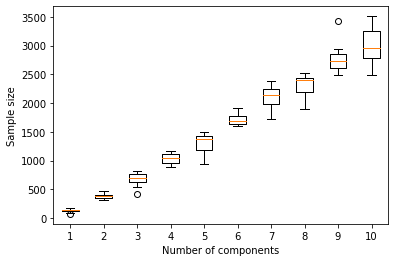

In [10]:
plt.boxplot(mean_res)
plt.xlabel('Number of components')
plt.ylabel('Sample size')

In [16]:
err = []
n_sqrt = math.sqrt(10)
for m in mean_res:
    std = np.std(m)
    err.append(round(std/n_sqrt,1))

In [17]:
err

[0.5, 0.7, 1.2, 0.7, 2.0, 1.0, 2.1, 2.1, 2.0, 2.9]

In [154]:
m = GMM(n_components=3).from_samples(geo[['Gross', 'Netpay']].values)

In [155]:
m.means

array([[1166.98118738,  159.1026037 ],
       [  36.2069098 ,   13.80837074],
       [ 168.10728445,   58.86814943]])

In [156]:
m.covariances

array([[[7.86946609e+05, 1.92546069e+04],
        [1.92546069e+04, 2.46692713e+04]],

       [[4.01122374e+02, 9.76328143e+01],
        [9.76328143e+01, 7.36824088e+01]],

       [[8.87962495e+03, 1.48485572e+03],
        [1.48485572e+03, 1.73659839e+03]]])

In [158]:

make_spd_matrix(2)

array([[ 4.99874425, -0.14000471],
       [-0.14000471,  1.05904253]])

In [147]:
mean_param

[[[-383]],
 [[566], [243]],
 [[-470], [-365], [238]],
 [[-907], [-63], [826], [-525]],
 [[-91], [432], [895], [425], [-704]],
 [[766], [-889], [-773], [784], [-477], [108]],
 [[-890], [-225], [-336], [-368], [798], [-573], [-833]],
 [[-755], [681], [-865], [599], [-398], [244], [-524], [970]],
 [[434], [-626], [569], [32], [175], [-251], [-399], [-139], [992]],
 [[660], [925], [-166], [244], [264], [289], [-502], [-192], [-570], [-689]],
 [[-388]],
 [[472], [-998]],
 [[442], [-371], [19]],
 [[382], [-937], [-106], [-300]],
 [[2], [923], [-772], [322], [659]],
 [[357], [-121], [724], [540], [308], [-765]],
 [[-549], [531], [534], [-106], [606], [-889], [222]],
 [[53], [-667], [-402], [811], [-554], [377], [-134], [465]],
 [[-865], [-982], [101], [-319], [252], [144], [-40], [-455], [191]],
 [[68], [820], [-626], [-199], [-512], [434], [-928], [-331], [-755], [152]],
 [[35]],
 [[-809], [-622]],
 [[-540], [-378], [-880]],
 [[798], [-701], [705], [-693]],
 [[-912], [-414], [-881], [-818], 

In [148]:
cov_param

[[[[388]]],
 [[[302]], [[376]]],
 [[[230]], [[107]], [[487]]],
 [[[500]], [[334]], [[282]], [[360]]],
 [[[207]], [[343]], [[271]], [[420]], [[296]]],
 [[[323]], [[428]], [[282]], [[104]], [[484]], [[479]]],
 [[[256]], [[107]], [[273]], [[401]], [[125]], [[466]], [[268]]],
 [[[443]], [[430]], [[165]], [[453]], [[309]], [[274]], [[113]], [[429]]],
 [[[453]],
  [[486]],
  [[487]],
  [[483]],
  [[428]],
  [[254]],
  [[293]],
  [[369]],
  [[336]]],
 [[[137]],
  [[201]],
  [[218]],
  [[121]],
  [[223]],
  [[214]],
  [[465]],
  [[294]],
  [[418]],
  [[468]]],
 [[[480]]],
 [[[284]], [[464]]],
 [[[451]], [[327]], [[187]]],
 [[[174]], [[289]], [[383]], [[362]]],
 [[[262]], [[409]], [[398]], [[249]], [[380]]],
 [[[241]], [[105]], [[259]], [[144]], [[351]], [[356]]],
 [[[410]], [[429]], [[235]], [[290]], [[218]], [[152]], [[363]]],
 [[[361]], [[166]], [[124]], [[134]], [[101]], [[131]], [[474]], [[110]]],
 [[[128]],
  [[117]],
  [[273]],
  [[109]],
  [[104]],
  [[208]],
  [[202]],
  [[251]],
  [[3

In [135]:
w_param

[[1.0],
 [0.5, 0.5],
 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 [0.25, 0.25, 0.25, 0.25],
 [0.2, 0.2, 0.2, 0.2, 0.2],
 [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 [1.0],
 [0.5, 0.5],
 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 [0.25, 0.25, 0.25, 0.25],
 [0.2, 0.2, 0.2, 0.2, 0.2],
 [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666

In [47]:
m = GMM(n_components=4, means=mean_param[3], covariances=cov_param[3], priors=w_param[3], random_state=random_state)

In [48]:
sample = m.sample(100000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

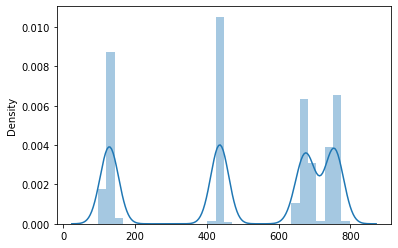

In [49]:
sns.distplot(sample)

In [50]:
m = GMM(n_components=5, means=mean_param[4], covariances=cov_param[4], priors=w_param[4], random_state=random_state)

In [51]:
sample = m.sample(100000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

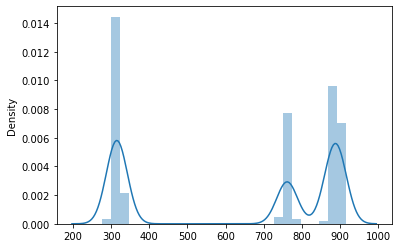

In [52]:
sns.distplot(sample)

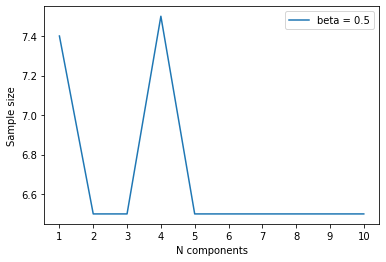

In [29]:
# plt.plot([i for i in range (1, 11, 1) ], results[0], label='beta = 0.99')
# plt.plot([i for i in range (1, 11, 1) ], results[1], label='beta = 0.95')
plt.plot([i for i in range (1, 11, 1) ], results[0], label='beta = 0.5')
plt.xlabel('N components')
plt.ylabel('Sample size')
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
plt.legend()

In [46]:
n_component(geo, ['Netpay', 'Gross'])

7

In [81]:
geo

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Depositional environment,Gross,Netpay,Porosity,Permeability,Depth,Oil density,Oil recovery factor
0,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,OIL,SHELF-,76.2,30.5,21.0,60.0,1510.7,825.072886,0.26
1,GRAVITY,CRETACEOUS,LIMESTONE,PASSIVE MARGIN,OIL,SHELF-,29.0,4.6,12.0,20.0,2652.4,801.699717,0.34
2,EXTENSION,PALEOGENE,THINLY-BEDDED SANDSTONE,RIFT,OIL,SLOPE APRON,91.5,82.3,35.0,3500.0,1720.1,933.993399,0.36
3,STRIKE-SLIP,ORDOVICIAN,DOLOMITE,INTRACRATONIC,OIL,OPEN SHELF,182.9,122.0,4.0,10.0,1158.5,815.561960,0.48
4,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,OIL,SHELF-,91.5,32.0,10.0,20.0,1829.3,876.160991,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,LACUSTRINE FAN-DELTA,50.0,18.9,23.2,121.0,1439.3,946.488294,0.13
339,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,SUBLACUSTRINE FAN,89.9,24.1,21.0,60.0,2310.7,881.619938,0.19
340,EXTENSION,MESOZOIC,VOLCANICS,RIFT,OIL,NOT APPLICABLE,150.0,59.1,12.7,3.6,3000.9,870.769231,0.05
341,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,OIL,SHORELINE,79.9,10.1,24.0,30.0,570.1,887.147335,0.24


In [110]:
geo_sample = geo.loc[(geo['Tectonic regime'] == 'EXTENSION') & (geo['Lithology'] == 'SANDSTONE') & (geo['Period'] == 'JURASSIC')]
geo_sample.groupby('Lithology')['Lithology'].count()

Lithology
SANDSTONE    15
Name: Lithology, dtype: int64

In [111]:
geo_sample.shape

(15, 13)

In [59]:
def lrts_comp(data):
    n = 0
    biggets_p = -1*np.infty
    comp_biggest = 0
    max_comp = 10
    if len(data) < max_comp:
        max_comp = len(data)
    for i in range (1, max_comp+1, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.mean(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.mean(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        if p > biggets_p:
            biggets_p = p
            comp_biggest = i
        n = comp_biggest
    return n

def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i][0], scale=covars[i][0][0])
    return mcdf

def theoretical_quantile (data, n_comp):
    model = GaussianMixture(n_components=n_comp,random_state=0)
    model.fit(data)
    q = []
    x = []
    #step =  ((np.max(model.sample(100000)[0])) - (np.min(model.sample(100000)[0])))/1000
    step =  (np.max(data) - np.min(data))/1000
    d = np.arange(np.min(data),np.max(data), step)
    for i in d:
        x.append(i)
        q.append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
    return x, q
def quantile_mix(p, vals, q):
    ind = q.index(min(q, key=lambda x:abs(x-p)))
    return vals[ind]
def probability_mix(val, vals, q):
    ind = vals.index(min(vals, key=lambda x:abs(x-val)))
    return(q[ind])
def sum_dist(data, vals, q):
    percs = np.linspace(1, 100, 10)
    x = np.quantile(data, percs/100)
    y = []
    for p in percs:
        y.append(quantile_mix(p/100, vals, q))
    dist = 0
    for xi,yi in zip(x,y):
        dist = dist + (abs(-1*xi + yi)) / math.sqrt(2)
    return dist


def component (data, columns, method):
    n = 1
    max_comp = 10
    x = []
    if data.shape[0] < max_comp:
        max_comp = data.shape[0]
    if len(columns) == 1:
        x = np.transpose([data[columns[0]].values])
    else:
        x = data[columns].values
    if method == 'aic':
        lowest_aic = np.infty
        comp_lowest = 0
        for i in range (1, max_comp+1, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0, reg_covar=0.0001)
            gm1.fit(x)
            aic1 = gm1.aic(x)
            if aic1 < lowest_aic:
                lowest_aic = aic1
                comp_lowest = i
            n = comp_lowest


    if method == 'bic':
        lowest_bic = np.infty
        comp_lowest = 0
        for i in range (1, max_comp+1, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0, reg_covar=0.0001)
            gm1.fit(x)
            bic1 = gm1.bic(x)
            if bic1 < lowest_bic:
                lowest_bic = bic1
                comp_lowest = i
            n = comp_lowest


    if method == 'LRTS':
        n = lrts_comp(x)
    if method == 'quantile':
        biggest_p = -1*np.infty
        comp_biggest = 0
        for i in range(1, max_comp, 1):
            vals, q = theoretical_quantile(x, i)
            dist = sum_dist(x, vals, q)
            p = probability_mix(dist, vals, q)
            if p > biggest_p:
                biggest_p = p
                comp_biggest = i
        n = comp_biggest
    return n

In [65]:
geo_sample = data.loc[data['has_pets'] == '0']

In [67]:
int((component(geo_sample, ['mean_tr', 'median_tr'], 'aic') + component(geo_sample, ['mean_tr', 'median_tr'], 'bic')) / 2)

7

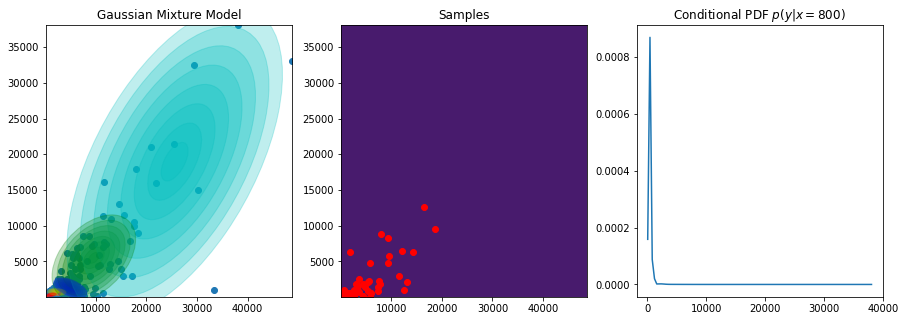

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = geo_sample.shape[0]
n_features = 2
# X = np.ndarray((n_samples, n_features))
# X[:n_samples // 3, :] = random_state.multivariate_normal(
#     [0.0, 1.0], [[0.5, -1.0], [-1.0, 5.0]], size=(n_samples // 3,))
# X[n_samples // 3:-n_samples // 3, :] = random_state.multivariate_normal(
#     [-2.0, -2.0], [[3.0, 1.0], [1.0, 1.0]], size=(n_samples // 3,))
# X[-n_samples // 3:, :] = random_state.multivariate_normal(
#     [3.0, 1.0], [[3.0, -1.0], [-1.0, 1.0]], size=(n_samples // 3,))
X = geo_sample[['mean_tr', 'median_tr']].values

gmm = GMM(n_components=7, random_state=random_state)
gmm.from_samples(X)
cond = gmm.condition(np.array([0]), np.array([800]))
x_min = np.min(geo_sample['mean_tr'].values)
x_max = np.max(geo_sample['mean_tr'].values)
y_min = np.min(geo_sample['median_tr'].values)
y_max = np.max(geo_sample['median_tr'].values)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Gaussian Mixture Model")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plot_error_ellipses(plt.gca(), gmm, colors=["c", "m", "y", "g", "b", "r", '#d62728'])
plt.scatter(X[:, 0], X[:, 1])

plt.subplot(1, 3, 2)
plt.title("Samples")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
X_test = np.vstack((x.ravel(), y.ravel())).T
p = gmm.to_probability_density(X_test)
p = p.reshape(*x.shape)
plt.contourf(x, y, p)
X_sampled = gmm.sample(100)
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], c="r")

plt.subplot(1, 3, 3)
plt.title("Conditional PDF $p(y | x = 800)$")
X_test = np.linspace(y_min, y_max, 100)
plt.plot(X_test, cond.to_probability_density(X_test[:, np.newaxis]))

plt.show()

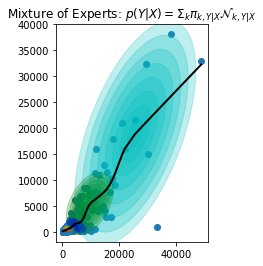

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = geo_sample.shape[0]
# X = np.ndarray((n_samples, 2))
# X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
# X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)
X = geo_sample[['mean_tr', 'median_tr']].values


X_test = np.array(sorted(geo_sample['mean_tr'].values))

gmm = GMM(n_components=7, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["c", "m", "y", "g", "b", "r", '#d62728'])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

In [15]:
def quantile2d(x,y,Nbins,nth):
    def myperc(x,n=nth):
        return(percentile(x,n))
    t=binned_statistic(x,y,statistic=myperc,bins=Nbins)
    v=[]
    for i in range(len(t[0])): v.append((t[1][i+1]+t[1][i])/2.)
    v=np.array(v)
    return(t,v)

In [25]:
x = geo['Permeability'].values
y = geo['Oil recovery factor'].values
Nbins=400
nth=95.
t,v=quantile2d(x,y,Nbins,nth)
ii=[]
for i in range(Nbins):
    ii=ii+np.argwhere(((t.binnumber==i) & (y<t.statistic[i]))).flatten().tolist()
ii=np.array(ii,dtype=int)

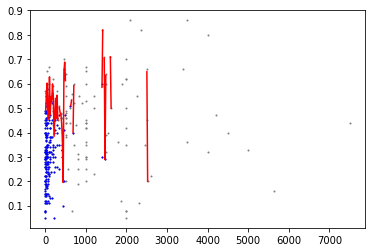

In [26]:
plt.plot(x,y,'o',color='gray',ms=1,zorder=1)
plt.plot(v,t.statistic,'r-',zorder=3)
plt.plot(x[ii],y[ii],'o',color='blue',ms=1,zorder=2)